Based on the DE marker results, as well as the aggregated scType cluster scores per cell type (ie, some of the top scores were not much larger than the second highest score), we decided clusters 2, 6, and 9 may be a mixture of cells that need to be further sub-clusterd

In [1]:
suppressPackageStartupMessages({
    library(Seurat, quietly = T)
    library(HGNChelper, quietly = T)
    
    library(dplyr, quietly = T)
    library(openxlsx, quietly = T)
    library(reshape2, quietly = T)
    library(data.table, quietly = T)
    library(gtools, quietly = T)
    
    library(ggplot2, quietly = T)
    library(RColorBrewer, quietly = T)
})

data_path = '/data3/hratch/STAT4_v2/'

In [2]:
pbmc.integrated<-readRDS(paste0(data_path, 'interim/pbmc_sctype_annotated.RDS'))

# Subclustering

To subcluster, we 1) subset to the cluster of interest then 2) re-run PCA and clustering on the subset.   

We expect 3-4 subclusters for cluter 2, 3 subclusters for cluster 6, and 2 subclusters for cluster 9, . We adjust the resolution parameter accordingly

Note, this uses the HVGs of the full batch-corrected data. This should still provide us enough resolution. If necessary, can go back and reprocess entirely from raw counts prior to clustering. 

In [69]:
pca.var<-function(so, n_pcs_test = 100, pc.thresh = 0.15){
    total_variance <- sum(matrixStats::rowVars(so@assays$integrated@scale.data))
    eigValues = (so@reductions$pca@stdev)^2
    varExplained = eigValues / total_variance


    viz_df = data.frame(varExplained)
    viz_df[['n_pcs']] = 1:dim(viz_df)[[1]]
    viz_df[['Variance.Explained']] = cumsum(viz_df$varExplained)

    n_pcs = min(which(diff(viz_df$Variance.Explained) < (pc.thresh/100))) # which PC is the additional variance explained < pc.thresh%
    print(paste0('Additional variance explained is <', pc.thresh, '% at ', n_pcs, ' pcs')) # 48!
    g<-ggplot(viz_df, aes(x=n_pcs, y=Variance.Explained)) + geom_point()
    if (n_pcs <= n_pcs_test){g<-g+geom_vline(xintercept = n_pcs, color = 'blue')}
    
    return(list(n.pcs = min(30, n_pcs), pc.var.graph = g))
}

subcluster<-function(so, cluster_label, resolution = 0.5, n_pcs_test = 100){
    suppressWarnings({
        suppressMessages({
            pbmc.subset<-subset(pbmc.integrated, seurat_clusters == cluster_label)
            pbmc.subset<-RunPCA(pbmc.subset, npcs = n_pcs_test, verbose=FALSE)
            # npcs is min(PC where more than 0.1% of var is no longer explained or 30)
            pca.res<-pca.var(pbmc.subset, n_pcs_test = n_pcs_test) 
            pbmc.subset <- FindNeighbors(pbmc.subset, reduction = "pca", dims = 1:pca.res$n.pcs)
            pbmc.subset <- FindClusters(pbmc.subset, resolution = resolution)
            pbmc.subset <- RunUMAP(pbmc.subset, reduction = "pca", dims = 1:pca.res$n.pcs)
        })
    })

    g<-DimPlot(pbmc.subset)
    
    res<-list(so.subset = pbmc.subset, 
              n.pcs = pca.res$n.pcs, pc.var.graph = pca.res$pc.var.graph, 
             umap.graph = g)
    return(res)
    
}

Cluster 2 gives 4 clusters:

In [87]:
res.c2<-subcluster(so = pbmc.integrated, cluster_label = '2', resolution = 0.15)

[1] "Additional variance explained is <0.15% at Inf pcs"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2082
Number of edges: 92731

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8788
Number of communities: 4
Elapsed time: 0 seconds


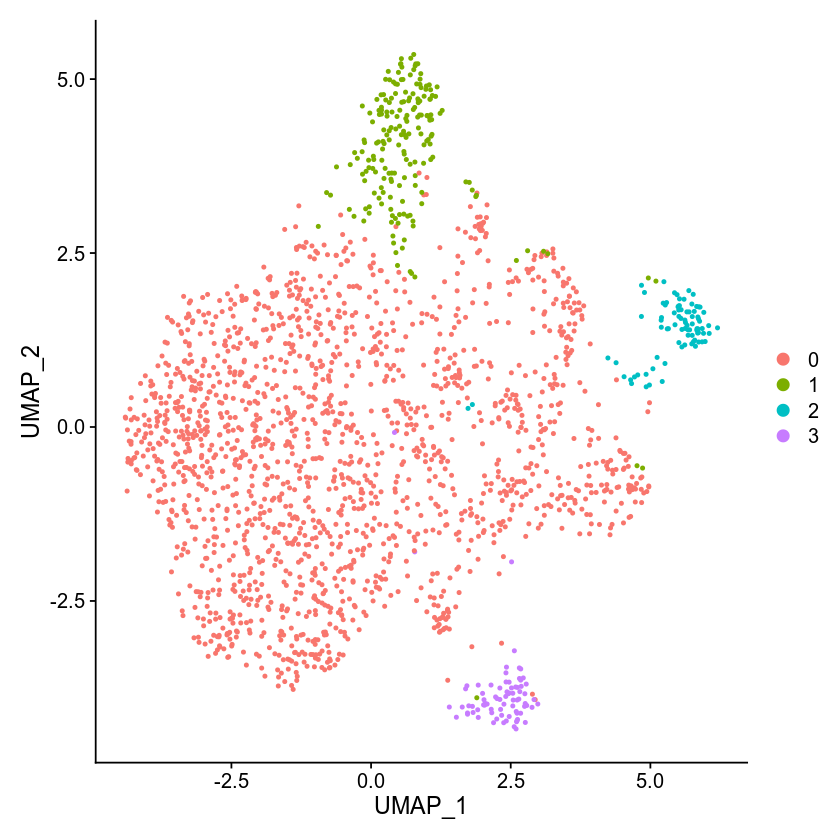

In [88]:
res.c2$umap.graph

In [74]:
res.c6<-subcluster(so = pbmc.integrated, cluster_label = '6', resolution = 0.2)

[1] "Additional variance explained is <0.15% at Inf pcs"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 947
Number of edges: 50454

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8231
Number of communities: 3
Elapsed time: 0 seconds


Cluster 6 gives 3 clusters:

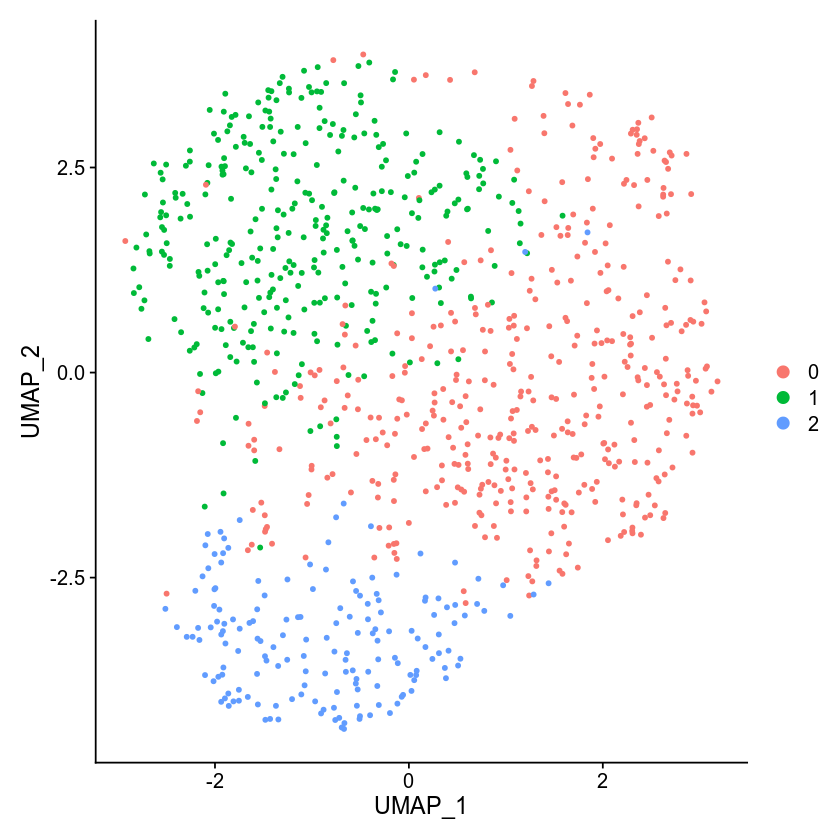

In [75]:
res.c6$umap.graph

Cluster 9 gives X clusters:

In [83]:
res.c9<-subcluster(so = pbmc.integrated, cluster_label = '9', resolution = 0.2)

[1] "Additional variance explained is <0.15% at Inf pcs"
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 385
Number of edges: 16698

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8571
Number of communities: 2
Elapsed time: 0 seconds


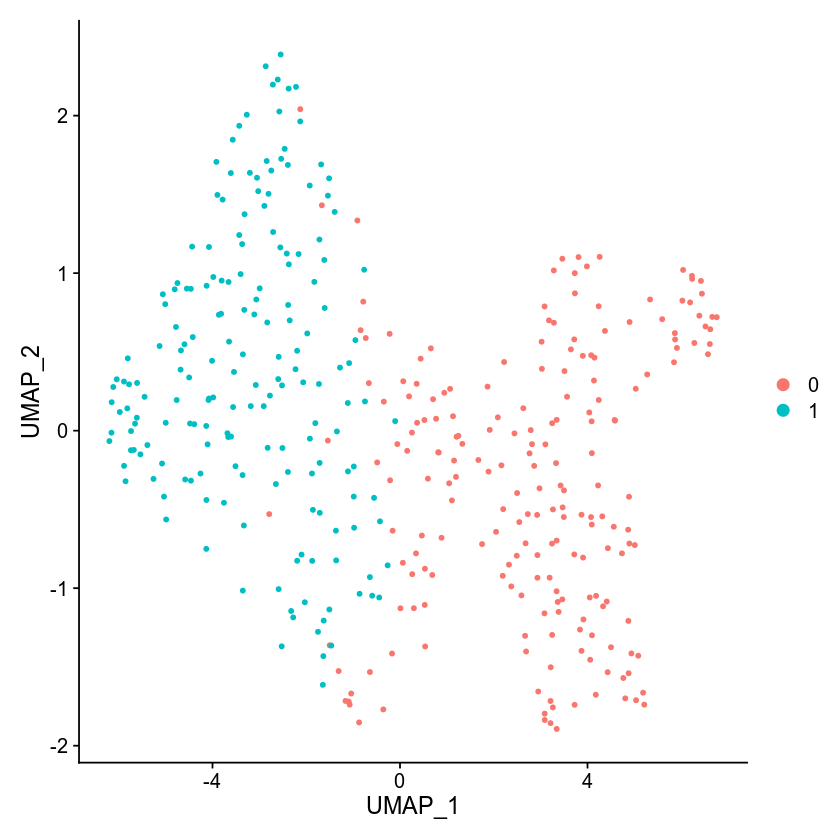

In [80]:
res.c9$umap.graph

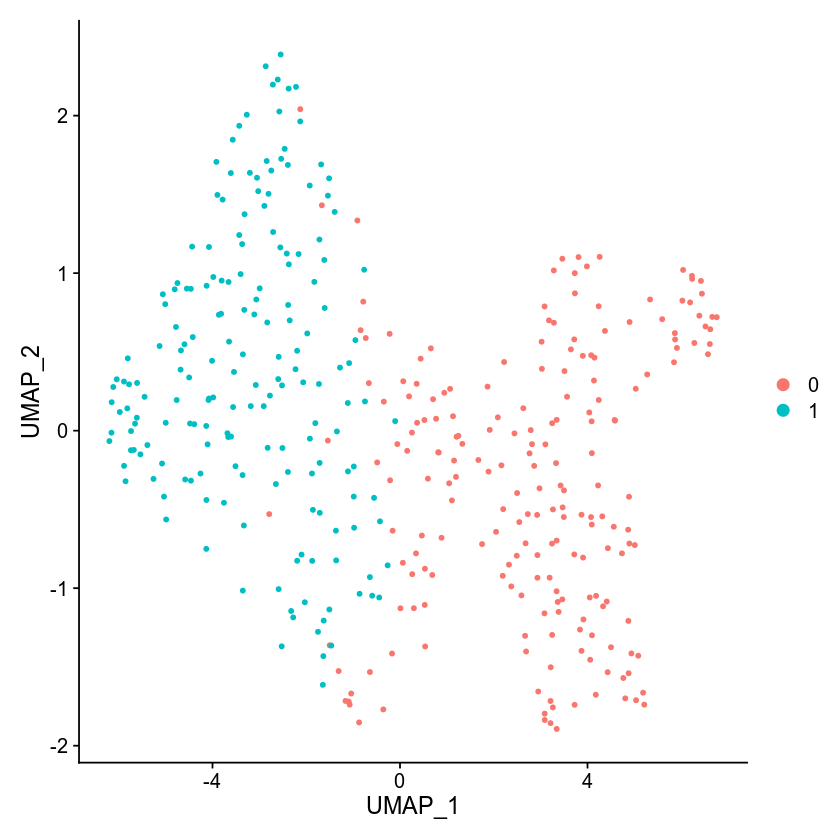

In [84]:
res.c9$umap.graph

# Markers

We repeat the marker wilcoxon method from before (02Ci), but this time, each of clusters 2, 6, and 9 are reannotated as new clusters with their subclusters. It's still one vs rest, so a subcluster of 2, for example, is tested against ALL other cells in the dataset (including other cells in cluster 2 and other cells otuside of cluster 2). 

## Mapping

First, must map cluster labels of subsets. So for cluster 2 with 4 subclusters since there are currently 16 present, this will become clusters 2, 17, 18, 19 (or also 2A-2D).

In [138]:
relabel.clusters<-function(so.subset, cluster.label.og, label.start){
    md<-so.subset@meta.data['seurat_clusters']
    n.clusters<-length(unique(md$seurat_clusters))
    cluster.labels<-sort(unique(as.numeric(md$seurat_clusters))) - 1

    cluster.labels.no<-c(cluster.label.og, 
                         seq(label.start+1, label.start+n.clusters - 1, by = 1))
    names(cluster.labels.no)<-as.character(cluster.labels)

    cluster.labels.let<-as.character(paste0(cluster.label.og, LETTERS[1:n.clusters]))
    md[['cluster.labels.no']]<-cluster.labels.no[md$seurat_clusters]
    md[['cluster.labels.let']]<-cluster.labels.let[md$seurat_clusters]
    
    so.subset@meta.data<-md
    
    return(list(so.subset = so.subset, max.cluster = max(cluster.labels.no)))
}

In [130]:
# cluster 2
clust.relabel.2<-relabel.clusters(so.subset = res.c2$so.subset, 
                                 cluster.label.og = 2, 
                                 label.start=max(as.numeric(pbmc.integrated@meta.data$seurat_clusters)) - 1)
res.c2[['so.subset']]<-clust.relabel.2$so.subset
label.start<-clust.relabel.2$max.cluster

# cluster 6
clust.relabel.6<-relabel.clusters(so.subset = res.c6$so.subset, 
                                 cluster.label.og = 6, 
                                 label.start=label.start)
res.c6[['so.subset']]<-clust.relabel.6$so.subset
label.start<-clust.relabel.6$max.cluster

# cluster 9
clust.relabel.9<-relabel.clusters(so.subset = res.c9$so.subset, 
                                 cluster.label.og = 9, 
                                 label.start=label.start)
res.c9[['so.subset']]<-clust.relabel.9$so.subset
label.start<-clust.relabel.9$max.cluster

In [150]:
res.clusters=list('2' = res.c2, 
                 '6' = res.c6, 
                 '9' = res.c9)

mapper.no<-c()
mapper.label<-c()
for (x in res.clusters){
    mapper.no<-c(mapper.no, setNames(x$so.subset@meta.data$cluster.labels.no, rownames(x$so.subset@meta.data)))
    mapper.label<-c(mapper.label, setNames(x$so.subset@meta.data$cluster.labels.let, rownames(x$so.subset@meta.data)))
}

In [ ]:
md<-pbmc.integrated@meta.data

md[['seurat_subcluster_no']]<-as.numeric(md$seurat_clusters) - 1
md[names(mapper.no), 'seurat_subcluster_no']<-unname(unlist(mapper.no))
md[['seurat_subcluster_no']]<-factor(x = md$seurat_subcluster_no,
                                     levels = sort(unique(md$seurat_subcluster_no)))

md[['seurat_subcluster_let']]<-as.character(md$seurat_clusters) 
md[names(mapper.label), 'seurat_subcluster_let']<-unname(unlist(mapper.label))
md[['seurat_subcluster_let']]<-factor(x = md$seurat_subcluster_let,
                                     levels = mixedsort(unique(md$seurat_subcluster_let)))
pbmc.integrated@meta.data<-md

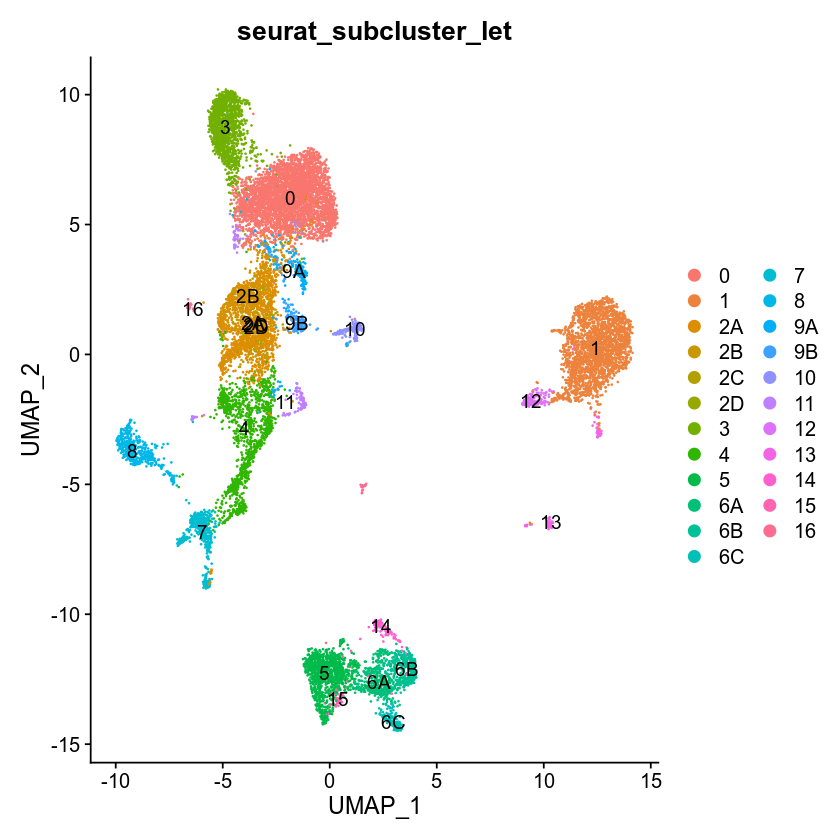

In [210]:
DimPlot(pbmc.integrated, 
       group.by = 'seurat_subcluster_let', label = T)

## Markers

In [220]:
markers.present<-colnames(fread(paste0(data_path, 'interim/scType_pos_markers.txt'))) # from 02Ci

In [222]:
Idents(pbmc.integrated)<-'seurat_subcluster_let'

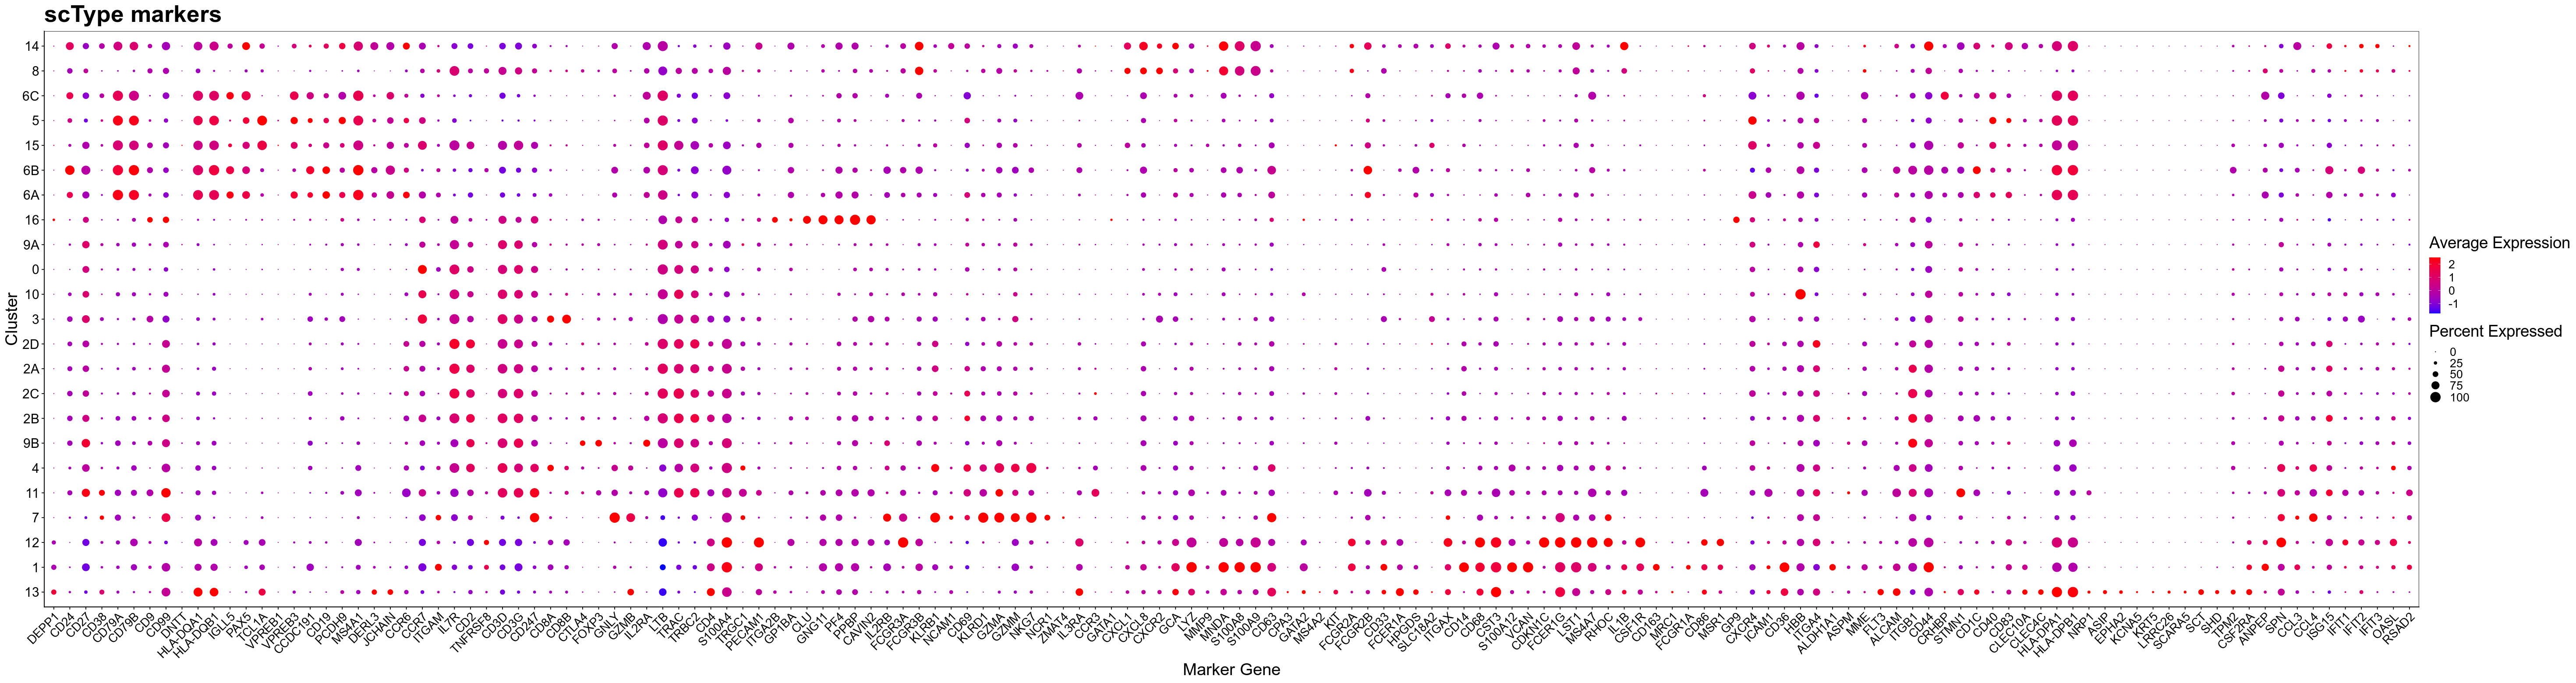

In [225]:
h_ = 13
w_ = 49
options(repr.plot.height=h_, repr.plot.width=w_)

theme = theme(panel.background = element_blank(), 
              panel.border = element_rect(colour = 'black', fill = 'NA'),
         text = element_text(size=28), panel.spacing = unit(1.15, "lines"), 
          axis.title=element_text(size=23), legend.text=element_text(size=16), 
         legend.title=element_text(size=22), axis.text.y = element_text(size = 18), 
              legend.key = element_blank(),
             axis.text.x = element_text(size = 16))
suppressWarnings({
    g<-DotPlot(pbmc.integrated, features = markers.present, cols = c('blue', 'red'), cluster.idents = T) + 
    RotatedAxis()+
    xlab('Marker Gene') + ylab('Cluster') + theme + ggtitle("scType markers")
})

for (ext in c('.svg', '.png', '.pdf')){ggsave(paste0(data_path, 'figures/processing/', 
                                                     'subclusters_scType_marker_dotplot', ext), g, 
                                             height = h_, width = w_)}

g

## DE & Markers

Since the Wilcoxon alone worked well last time, we can just proceed with this.

In [240]:
Idents(pbmc.integrated)<-'seurat_subcluster_let'
subclusters<-sort(unique(md[md$seurat_clusters %in% c('2', '6', '9'), 'seurat_subcluster_let']))

In [302]:
markers.wilcoxon<-list()
for (subcluster in subclusters){
    de.res<-FindMarkers(object = pbmc.integrated, 
                                    ident.1 = subcluster,
                                    assay = 'RNA', only.pos = T, 
                                       slot = 'data', test.use = 'wilcox', 
                                       min.pct = 0.25, # stringent since markers
                                        logfc.threshold = 0.5, 
                                      )
    de.res[['gene']]<-rownames(de.res)
    de.res[['seurat_cluster_let']]<-subcluster
    
    markers.wilcoxon[[subcluster]]<-de.res
}
saveRDS(markers.wilcoxon, paste0(data_path, 'interim/subcluster_markers.RDS'))

In [315]:
markers.wilcoxon<-readRDS(paste0(data_path, 'interim/subcluster_markers.RDS'))

In [316]:
# format markers
marker.excel<-function(marker, de.type = 'wilcoxon'){
    markers_workbook<-createWorkbook()
    for (cluster in mixedsort(unique(marker$seurat_cluster_let))){
        de.res.cl<-as.data.frame(marker[marker$seurat_cluster_let == cluster, ])
        rownames(de.res.cl)<-1:dim(de.res.cl)[[1]]

        addWorksheet(markers_workbook, cluster)
        writeData(markers_workbook, sheet = cluster, x = de.res.cl)
    }
    saveWorkbook(markers_workbook, overwrite = T, 
                 paste0(data_path, 'interim/', de.type, '_subcluster_markers.xlsx'))
}

# additional formatting and filtering
marker<-do.call("rbind", markers.wilcoxon)
marker<-marker[marker$p_val_adj <= 0.05,] # threshold on p_adj
marker<-marker[marker$avg_log2FC > 1.5,] # further threshold on LFC
marker<-marker[with(marker, order(seurat_cluster_let, -avg_log2FC)), ] # sort by effect size
md.subs<-md[md$seurat_clusters %in% c('2', '6', '9') ,]
mapper<-setNames(md.subs$seurat_subcluster_no, md.subs$seurat_subcluster_let)
marker[['seurat_subcluster_no']]<-unlist(unname(mapper[marker$seurat_cluster_let]))
marker.excel(marker) # save to excel file

# Subcluster Annotation